<!--NAVIGATION-->

_______________
Este documento puede ser utilizado de forma interactiva en las siguientes plataformas: 

- [Google Colab](https://colab.research.google.com/github/masdeseiscaracteres/ml_course/blob/master/material/03_03_feature_selection_wrapper_embedded_methods.ipynb)
- [MyBinder](https://mybinder.org/v2/gh/masdeseiscaracteres/ml_course/master)
- [Deepnote](https://deepnote.com/launch?template=python_3.6&url=https%3A%2F%2Fgithub.com%2Fmasdeseiscaracteres%2Fml_course%2Fblob%2Fmaster%2Fmaterial%2F03_03_feature_selection_wrapper_embedded_methods.ipynb)


_______________

# Métodos Wrapper y Embedded

En este notebook se revisarán los conceptos de:

1. Métodos *wrapper* para selección de características
2. Métodos *embedded* para selección de características

Primero cargamos librerías y funciones necesarias.


## 0. Configuración del entorno

In [1]:
# clonar el resto del repositorio si no está disponible
import os
curr_dir = os.getcwd()
if not os.path.exists(os.path.join(curr_dir, '../.ROOT_DIR')):
    !git clone https://github.com/masdeseiscaracteres/ml_course.git ml_course
    os.chdir(os.path.join(curr_dir, 'ml_course/material'))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

# 1. Métodos *wrapper*

Estos métodos utilizan un algoritmo de machine learning como caja negra para ordenar distintos subconjuntos de variables de acuerdo a su capacidad predictiva. Normalmente se usan procedimientos "hacia delante/atrás" en combinación con validación cruzada.

### *The wrong and right way to do cross-validation*

Este ejemplo ha sido inspirado en la Sección 7.10.2 *The Wrong and Right Way to Do Cross-validation* del libro
"*The Elements of Statistical Learning*" de Hastie, Tibshirani y Friedman.

Average error rate (%): 3.5719999999999974


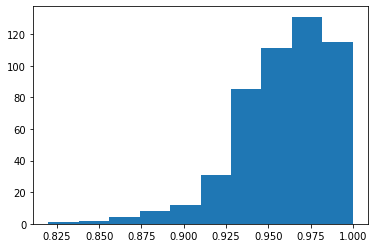

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif


# This is the WRONG way

np.random.seed(0)
score = []

for i in range(500): # This is run for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)), np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors are random variables!!
    
    
    # Note here, the ranking and selection is performed outside the CV loop
    f_test, _ = f_classif(X, y)
    f_test /= np.max(f_test)
    
    ranking = np.argsort(f_test)[::-1] 
    selected = ranking[0:50]
    Xs = X[:, selected]
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train_idx, val_idx in kf.split(Xs):
        knn.fit(Xs[train_idx,:], y[train_idx])
        accuracy = knn.score(Xs[val_idx,:], y[val_idx])
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Average error rate (%): " + str((1 - np.mean(score))*100))

plt.hist(score)
plt.show()

En una situación como esta, en la que las features no tienen ningún tipo de relación con la variable objetivo, esperamos un error de clasificación medio del 50%. Sin embargo, hemos obtenido un error de clasificación medio del 3.5%. Esto es un indicador claro de que hemos realizado mal el experimento. Pero, ¿por qué ocurre esto?
- Como solo tenemos 50 ejemplos y un total de 5000 variables, es normal que alguna de las variables esté muy correlada con la variable objetivo.
- Estamos haciendo la selección de variables con la totalidad de los datos, por tanto, las variables que seleccionamos tienen alguna relación con la variable objetivo en cualquiera de los folds de la validación cruzada.

Para hacer la evaluación correctamente deben utilizarse solamente las muestras en el conjunto de entrenamiento como se muestra a continuación:

Error rate (%): 52.664


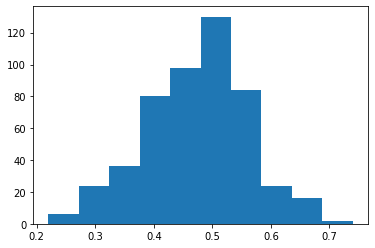

In [4]:
# This is the RIGHT way

np.random.seed(0)
score = []

for i in range(500): # This runs for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)), np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors, again random variables
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train_idx, val_idx in kf.split(Xs):
        
        # Note here, the ranking and selection is performed inside the CV loop
        f_test, _ = f_classif(X[train_idx,:], y[train_idx])
        f_test /= np.max(f_test)
        ranking = np.argsort(f_test)[::-1] 
        selected = ranking[0:50]
        
        Xs = X[:, selected]
           
        knn.fit(Xs[train_idx,:], y[train_idx])
        accuracy = knn.score(Xs[val_idx,:], y[val_idx])
        
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1 - np.mean(score))*100))

plt.hist(score)
plt.show()

En este caso sí que obtenemos una probabilidad cercana al 50%. Por tanto, estamos realizando correctamente la selección de variables.

Este es el procedimiento general que se debe seguir cuando se implementa validación cruzada con métodos wrapper. Además puedes apoyarte en algunas funciones ya implementadas en `sklearn` para hacer la tarea más fácil:
- [`sklearn.feature_selection.SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)
- [`sklearn.feature_selection.RFE`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)



# 2. Métodos *embedded*

Vamos a trabajar directamente sobre la base de datos  de viviendas [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction), así que lo primero es cargar los datos:

In [5]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years'] = 2019 - house_data['yr_built']
house_data = house_data.drop(['yr_built','sqm_above'], axis=1)
house_data = house_data[house_data.sqm_living <= 600]


#house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
#house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
#house_data['lat_plus_long']    = house_data['lat']*house_data['long']

house_data.head()

      price  bedrooms  bathrooms  sqm_living     sqm_lot  floors  waterfront  \
0  221900.0         3       1.00  109.625587  524.902176     1.0           0   
1  538000.0         3       2.25  238.760813  672.803816     2.0           0   
2  180000.0         2       1.00   71.535341  929.030400     1.0           0   
3  604000.0         4       3.00  182.089958  464.515200     1.0           0   
4  510000.0         3       2.00  156.077107  750.656563     1.0           0   

   view  condition  grade  sqm_basement  yr_renovated  zip_code      lat  \
0     0          3      7      0.000000             0     98178  47.5112   
1     0          3      7     37.161216          1991     98125  47.7210   
2     0          3      6      0.000000             0     98028  47.7379   
3     0          5      7     84.541766             0     98136  47.5208   
4     0          3      8      0.000000             0     98074  47.6168   

      long  sqm_living15   sqm_lot15  years  bed_bath_rooms  


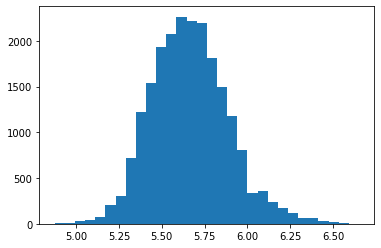

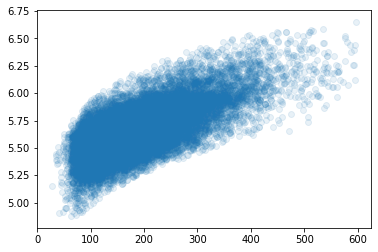

In [6]:
plt.hist(np.log10(house_data.price), bins=30)
plt.show()

plt.scatter(house_data.sqm_living, np.log10(house_data.price), alpha=0.1)
plt.show()

In [7]:
house_data.describe().T

                  count           mean            std           min  \
price           21568.0  534959.642433  341357.402350  75000.000000   
bedrooms        21568.0       3.367350       0.926683      0.000000   
bathrooms       21568.0       2.108436       0.756119      0.000000   
sqm_living      21568.0     192.148022      81.843245     26.941882   
sqm_lot         21568.0    1389.661587    3791.006065     48.309581   
floors          21568.0       1.493231       0.539595      1.000000   
waterfront      21568.0       0.007233       0.084741      0.000000   
view            21568.0       0.230759       0.758944      0.000000   
condition       21568.0       3.409774       0.651011      1.000000   
grade           21568.0       7.648322       1.160938      1.000000   
sqm_basement    21568.0      26.802471      40.402986      0.000000   
yr_renovated    21568.0      84.022302     400.811921      0.000000   
zip_code        21568.0   98077.991098      53.496889  98001.000000   
lat   

In [8]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values.copy()

#y = data[:, 0]     # nos quedamos con la 1ª columna, price
y = np.log10(data[:, 0])     # nos quedamos con la 1ª columna, log-price
X = data[:, 1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Escalar todos los datos en este punto es INCORRECTO!! 
# X_mal = preprocessing.StandardScaler().fit_transform(X)

# Dividimos los datos en entrenamiento y test (75% training, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Escalamos (obtenemos la transformación con los datos de train y la aplicamos a train y a test)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Datos entrenamiento:  (16176, 18)
Datos test:  (5392, 18)


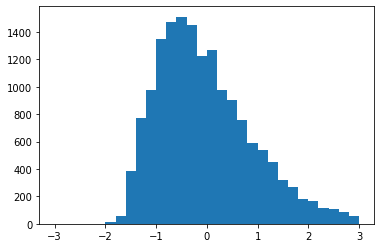

In [10]:
plt.hist(X_train_scaled[:,2], range = [-3, 3], bins=30)
plt.show()

En este caso, utilizamos la capacidad de LASSO para seleccionar variables. Recordemos que, para que los coeficientes de LASSO reflejen adecuadamente la importancia real de las variables, estas tiene que haber sido normalizadas con anterioridad.

best mean cross-validation score: -0.012
best parameters: {'alpha': 3.856620421163472e-05}


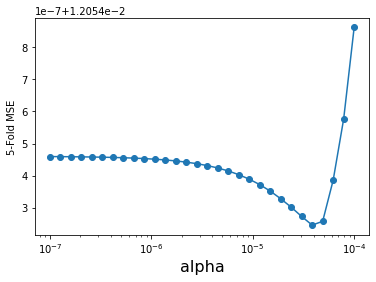

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

K = 5 # número de folds

# Rango de búsqueda del parámetro de regularización (mejor en escala logarítmica)
# primera iteración
# alpha_vector = np.logspace(-7, 10, 50)
# segunda iteración (zoom)
# alpha_vector = np.logspace(-7, -2, 20)
# tercera iteración (zoom)
alpha_vector = np.logspace(-7, -4, 30)

param_grid = {'alpha': alpha_vector}
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = K)
grid.fit(X_train_scaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector, scores,'-o')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('{}-Fold MSE'.format(K))
#plt.ylim((-1, 0))
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error 

alpha_optimo = grid.best_params_['alpha']

lasso = Lasso(alpha = alpha_optimo).fit(X_train_scaled, y_train)

ytrainLasso = lasso.predict(X_train_scaled)
ytestLasso  = lasso.predict(X_test_scaled)
mseTrainModelLasso = mean_squared_error(y_train, ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test, ytestLasso)

print('alpha: %0.3g' % alpha_optimo)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f, wi in zip(feature_names, w):
    print("{}: {}".format(f, wi))

alpha: 3.86e-05
MSE Modelo Lasso (train): 0.012
MSE Modelo Lasso (test) : 0.0116
RMSE Modelo Lasso (train): 0.11
RMSE Modelo Lasso (test) : 0.108
bedrooms: -0.000963564696302832
bathrooms: 0.029626807946157924
sqm_living: 0.05805031473146197
sqm_lot: 0.0078085189780189804
floors: 0.01720128096115008
waterfront: 0.013303691381806487
view: 0.02061628415148574
condition: 0.01735189156948818
grade: 0.07800590327151843
sqm_basement: 0.0022569488941406235
yr_renovated: 0.006404272226372331
zip_code: -0.014766125853516323
lat: 0.08396147348986463
long: -0.010226765867101759
sqm_living15: 0.027522168401515983
sqm_lot15: -0.0019638101498149056
years: 0.04379627617319116
bed_bath_rooms: -0.010902114793609134


Como puede apreciarse, aparecen algunas incoherencias con respecto al valor esperado de los coeficientes, como por ejemplo el asociado a la variable `bedrooms` que tiene valor negativo. No tiene sentido que el precio de la vivienda disminuya si aumenta el número de habitaciones.

Vamos a aumentar el parámetro de regularización y observar los resultados obtenidos:

In [13]:
alpha_optimo = 1e-2
lasso = Lasso(alpha = alpha_optimo).fit(X_train_scaled, y_train)

ytrainLasso = lasso.predict(X_train_scaled)
ytestLasso  = lasso.predict(X_test_scaled)
mseTrainModelLasso = mean_squared_error(y_train, ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test, ytestLasso)

print('alpha: %0.3g' % alpha_optimo)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f, wi in zip(feature_names, w):
    print("{}: {}".format(f, wi))

alpha: 0.01
MSE Modelo Lasso (train): 0.013
MSE Modelo Lasso (test) : 0.0126
RMSE Modelo Lasso (train): 0.114
RMSE Modelo Lasso (test) : 0.112
bedrooms: 0.0
bathrooms: 0.011077110559891015
sqm_living: 0.06381332434681627
sqm_lot: 0.0
floors: 0.0009238614833627659
waterfront: 0.006818684134718069
view: 0.018781382429581116
condition: 0.009131466384560418
grade: 0.07572023663115744
sqm_basement: 0.0
yr_renovated: 0.0015884059734067096
zip_code: -0.0
lat: 0.075622233334306
long: -0.0
sqm_living15: 0.019104233003169397
sqm_lot15: 0.0
years: 0.023236472378938288
bed_bath_rooms: 0.0


Hemos aumentado el error ligeramente, pero a cambio:

1. Tenemos un modelo más sencillo (menos variables al haber muchos coeficientes nulos) y, por tanto, menos susceptible a sufrir *overfitting*.
2. Mejoramos la interpretabilidad del modelo: las variables supervivientes (con coeficientes distintos de cero) parecen concordar con nuestra intuición sobre el problema a resolver.

Y una vez llegados a este punto, ¿qué podemos hacer? El error de entrenamiento/validación y test es similar, pero todavía es muy alto, así que: 

1. Se podrían definir nuevas variables que nos ayuden a mejorar el error de predicción.
2. Jugar con el parámetro de regularización, para mantener el compromiso entre sencillez/interpretabilidad del modelo y error de predicción.
3. Utilizar un modelo un modelo más expresivo, pero no debemos olvidar que debemos seguir controlando el sobreajuste.

